In [1]:
# --- IMPORTS ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [17]:
subject = 1
Left = True
train_files = []

for i in range(3,13):
    if Left:
       if i % 2 == 0:
        train_files.append("parsed_emg/subject_" + str(subject) + "/trial_" + str(i) + "(left).csv")
    else:
        if i % 2 == 1:
            train_files.append("parsed_emg/subject_" + str(subject) + "/trial_" + str(i) + "(right)csv") 

if Left:
    test_file = "parsed_emg/subject_" + str(subject) + "/trial_2(left).csv"
else:
    test_file = "parsed_emg/subject_" + str(subject) + "/trial_1(right).csv"

label_col = 5
batch_size = 64
learning_rate = 1e-4
epochs = 1
num_classes = 3

# --- LOAD CSV with raw time ---
def load_csv_with_time(path):
    df = pd.read_csv(path, skiprows=1)
    time = df.iloc[:, 0].values.astype("float32").reshape(-1, 1)     # time
    emg = df.iloc[:, 1:5].values.astype("float32")                   # EMG
    X_time = time
    X_emg = emg
    y = df.iloc[:, label_col].values.astype("int32")
    return X_time, X_emg, y


Class weights: {0: np.float64(0.7613599991228824), 1: np.float64(0.8690622678681006), 2: np.float64(1.866035958020948)}
Class weights: {0: np.float64(1.5227199982457649), 1: np.float64(1.7381245357362012), 2: np.float64(3.732071916041896)}
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 34s 986us/step - accuracy: 0.7149 - loss: 1.2862 - val_accuracy: 0.8183 - val_loss: 0.4279
4408/4408 ━━━━━━━━━━━━━━━━━━━━ 3s 627us/step - accuracy: 0.8092 - loss: 0.5757

Test accuracy: 0.49, Test loss: 1.36


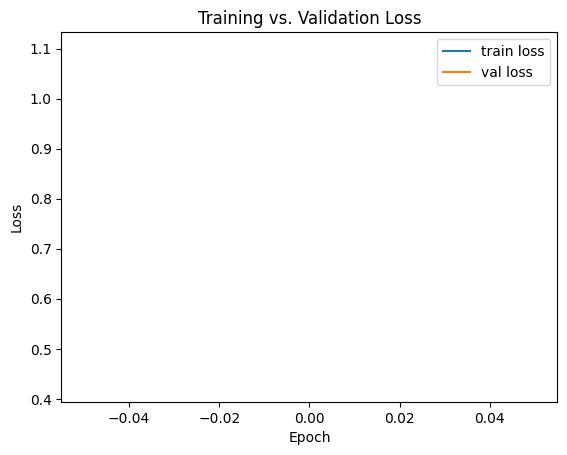

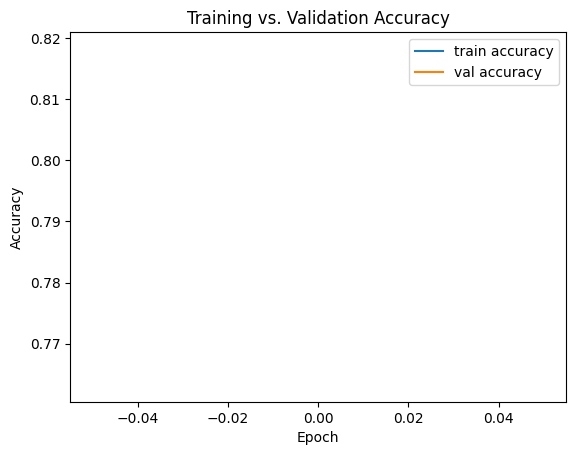

4408/4408 ━━━━━━━━━━━━━━━━━━━━ 3s 585us/step


<Figure size 640x480 with 0 Axes>

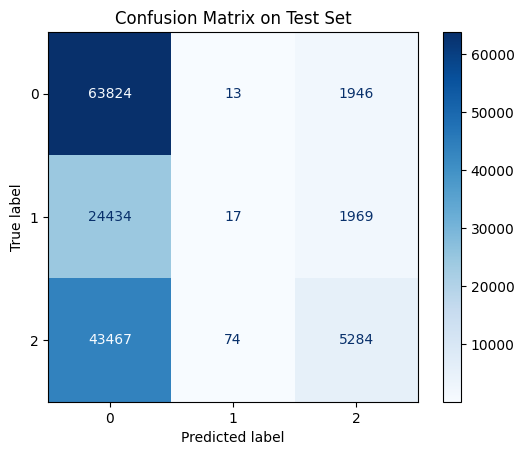

In [22]:
# --- LOAD + NORMALIZE ---
X_time_all, X_emg_all, y_all = [], [], []
for f in train_files:
    t, e, y = load_csv_with_time(f)
    X_time_all.append(t)
    X_emg_all.append(e)
    y_all.append(y)
X_time_all = np.concatenate(X_time_all)
X_emg_all = np.concatenate(X_emg_all)
y_all = np.concatenate(y_all)

# Normalize EMG and time separately
scaler_time = MinMaxScaler(feature_range=(-1, 1))
scaler_emg = MinMaxScaler(feature_range=(-1, 1))
X_time_all = scaler_time.fit_transform(X_time_all)
X_emg_all = scaler_emg.fit_transform(X_emg_all)

# --- TRAIN / VAL SPLIT ---
X_time_train, X_time_val, X_emg_train, X_emg_val, y_train, y_val = train_test_split(
    X_time_all, X_emg_all, y_all, test_size=0.1, random_state=42, stratify=y_all
)

# --- TF Datasets ---
train_ds = tf.data.Dataset.from_tensor_slices(
    ({"time": X_time_train, "emg": X_emg_train}, y_train)
).shuffle(10000).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices(
    ({"time": X_time_val, "emg": X_emg_val}, y_val)
).batch(batch_size)

# --- TEST SET ---
X_time_test, X_emg_test, y_test = load_csv_with_time(test_file)
X_time_test = scaler_time.transform(X_time_test)
X_emg_test = scaler_emg.transform(X_emg_test)

# --- CLASS WEIGHTS ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# --- MODEL ---
input_time = layers.Input(shape=(1,), name="time")
input_emg = layers.Input(shape=(4,), name="emg")

# Time branch
x_time = layers.Dense(8, activation='relu')(input_time)
x_time = layers.Dense(4, activation='relu')(x_time)
x_time = layers.BatchNormalization()(x_time)

# EMG branch
x_emg = layers.Dense(128, activation='relu')(input_emg)
x_emg = layers.Dropout(0.3)(x_emg)
x_emg = layers.Dense(64, activation='relu')(x_emg)
x_emg = layers.BatchNormalization()(x_emg)

# Merge branches
x = layers.concatenate([x_time, x_emg])
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(num_classes, activation='softmax')(x)

# Compile
model = tf.keras.Model(inputs={"time": input_time, "emg": input_emg}, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# --- TRAINING ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,  # Increased with early stopping
    class_weight=class_weight_dict,
)

# --- EVALUATION ---
test_loss, test_acc = model.evaluate({"time": X_time_test, "emg": X_emg_test}, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}")

# --- PLOTS ---
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.savefig('Val_loss.png')
plt.show()


plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.savefig('val_acc.png')
plt.show()


# Confusion matrix
y_pred = model.predict({"time": X_time_test, "emg": X_emg_test}).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
plt.figure()
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix on Test Set')
plt.savefig('cMAX.png')
plt.show()
